In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import awkward as ak
import numpy as np
import boost_histogram as bh

from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import awkward as ak

In [3]:
# Load events

events = NanoEventsFactory.from_root(
    #'/home/users/hbronson/CMSSW_11_3_1_patch1/src/Phase2Timing/ntuple_phase2timing0mm.root',
    '/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_0mm.root',
    schemaclass = BaseSchema,
    treepath='demo/tree',
    entry_stop = 100).events()
'''
# Load events
events = NanoEventsFactory.from_root(
    #'/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/ntuple_phase2timing1000mm.root',
    '/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_1000mm.root',
    schemaclass = BaseSchema,
    treepath='demo/tree',
    entry_stop = 100000).events()'''

"\n# Load events\nevents = NanoEventsFactory.from_root(\n    #'/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/ntuple_phase2timing1000mm.root',\n    '/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_1000mm.root',\n    schemaclass = BaseSchema,\n    treepath='demo/tree',\n    entry_stop = 100000).events()"

In [18]:
dir(events)

['LLP_eta',
 'LLP_mass',
 'LLP_phi',
 'LLP_pt',
 'Mask',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__self_class__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__thisclass__',
 '_behavior',
 '_caches',
 '_layout',
 '_numbaview',
 'add_kind',
 'add_systematic',
 'behavior',
 'caches',
 'describe_variations',
 'e_ctau',
 'e_ebdelay',
 'e_ebeta',
 'e_ebphi',
 'e_eta',
 'e_hgdelay',
 'e_hgeta',
 'e_hgphi',
 'e_phi',
 'e_pt',
 'e_vx',
 'e_vy',
 'e_vz',
 'explodes_how',
 'fields',
 'gp_energy_btl_hits',
 'gp_energy_etl_hits',
 'gp_eta_btl_hits',
 'gp_eta_etl_hits',
 'gp_phi_btl_hits',
 'gp_phi_etl_hits',
 'gp_theta_btl_hits',
 'gp_theta_etl_hits',
 'gp_time_btl_hits',
 'gp_time_etl_hits',
 'gp_x_btl_hits',
 'gp_x_etl_hits',
 'g

In [4]:
etl_eta = events['gp_eta_etl_hits']
etl_phi = events['gp_phi_etl_hits']

btl_eta = events['gp_eta_btl_hits']
btl_phi = events['gp_phi_btl_hits']

mtd_eta_hits = ak.concatenate((btl_eta, etl_eta), axis = 1)
mtd_phi_hits = ak.concatenate((btl_phi, etl_phi), axis = 1)

reco_pho_eta = events['reco_photon_eta']
reco_pho_phi = events['reco_photon_phi']

#electrons, but all of these give the same thing
reco_ele_eta = events['e_eta']
reco_ele_phi = events['e_phi']

gen_ele_eta = events['e_ebeta']
gen_ele_phi = events['e_ebphi']

gen_ele_eta1 = events['e_hgeta']
gen_ele_phi1 = events['e_hgphi']

#electorn cut for eta<3.1
reco_ele_phi = reco_ele_phi[abs(reco_ele_eta) < 3.1]
reco_ele_eta = reco_ele_eta[abs(reco_ele_eta) < 3.1]

track_eta = events['track_eta']
track_phi = events['track_phi']

#pt cut for tracks
track_pt = events['track_pt'] 
pt_5_cut = track_pt > 5
track_eta_w_cut = track_eta[pt_5_cut]
track_phi_w_cut = track_phi[pt_5_cut]

#times
btl_times = events['gp_time_btl_hits']
etl_times = events['gp_time_etl_hits']

eb_delay = events['e_ebdelay']
hg_delay = events['e_hgdelay']
barrel_eta_cut = abs(reco_ele_eta) < 1.48

ele_delay_times = (ak.concatenate([eb_delay[barrel_eta_cut],hg_delay[~barrel_eta_cut]], axis = 1))
mtd_times = (ak.concatenate([btl_times, etl_times], axis = 1))

btl_energy = events['gp_energy_btl_hits']
etl_energy = events['gp_energy_etl_hits']
mtd_energy = ak.concatenate((btl_energy, etl_energy), axis=1)

ele_pt = events['e_pt']

#these are in cm?
bx = events['gp_x_btl_hits']
ex = events['gp_x_etl_hits']
mtd_x = ak.concatenate((bx, ex), axis=1)
by = events['gp_y_btl_hits']
ey = events['gp_y_etl_hits']
mtd_y = ak.concatenate((by, ey), axis=1)
bz = events['gp_z_btl_hits']
ez = events['gp_z_etl_hits']
mtd_z = ak.concatenate((bz, ez), axis=1)

etl_theta = events['gp_theta_etl_hits']
btl_theta = events['gp_theta_btl_hits']
mtd_theta = ak.concatenate((btl_theta, etl_theta), axis=1)
RH_time = events['reco_photon_MTDtime']
RH_energy = events['reco_photon_MTDenergy']


In [5]:
#calc the time delay
v = 29.9792458 

tof = ((abs( mtd_x**2 + mtd_y**2 + mtd_z**2 )**0.5)/ v)
mtd_delays = mtd_times - tof
    
time_bins = np.linspace(-5, 25, 31)

In [6]:
#finds overlaps of photons and eles
r2_val = 0.1**2
overlaps_eta = []
overlaps_phi = []
overlaps_delay = []
mtdRH_time = []
mtdRH_energy = []
photon_match_mask = []

for i in range(len(reco_pho_phi)): #for each event
    tmp_time = []
    tmp_mask = []
    if i >= 0:
        for j in range(len(reco_pho_phi[i])): #loops through the photons
            tmp = False
            for k in range(len(reco_ele_phi[i])): #loops through the eles
                        
                if ((reco_pho_phi[i][j] - reco_ele_phi[i][k])**2 + (reco_pho_eta[i][j] - reco_ele_eta[i][k])**2) < r2_val:
                        
                    tmp_time.append(ele_delay_times[i][k])
                    tmp = True
            tmp_mask.append(tmp)
        overlaps_delay.append(tmp_time)
        photon_match_mask.append(tmp_mask)

mtdRH_time = RH_time[photon_match_mask]
mtdRH_energy = RH_energy[photon_match_mask]
overlaps_eta = reco_pho_eta[photon_match_mask]
overlaps_phi = reco_pho_phi[photon_match_mask]

In [7]:
'''#finds overlaps of photons and eles
r2_val = 0.1**2
overlaps_eta = []
overlaps_phi = []
overlaps_delay = []
mtdRH_time = []
mtdRH_energy = []
photon_match_mask = []

for i in range(len(reco_pho_phi)): #for each event
    tmp_time = []
    tmp_mask = []
    if len(reco_pho_phi[i]) <= len(reco_ele_phi[i]):
        for j in range(len(reco_pho_phi[i])): #loops through the photons
            tmp = False
            for k in range(len(reco_ele_phi[i])): #loops through the eles
                if ((reco_pho_phi[i][j] - reco_ele_phi[i][k])**2 + (reco_pho_eta[i][j] - reco_ele_eta[i][k])**2) < r2_val:
                    tmp_time.append(ele_delay_times[i][k])
                    tmp = True
            tmp_mask.append(tmp)
        overlaps_delay.append(tmp_time)
        photon_match_mask.append(tmp_mask)
    else:
        for j in range(len(reco_ele_phi[i])):
            tmp = False
            for k in range(len(reco_pho_phi[i])):
                if ((reco_ele_phi[i][j] - reco_pho_phi[i][k])**2 + (reco_ele_eta[i][j] - reco_pho_eta[i][k])**2) < r2_val:
                    tmp_time.append(ele_delay_times[i][j])
                    tmp = True
            tmp_mask.append(tmp)
        overlaps_delay.append(tmp_time)
        photon_match_mask.append(tmp_mask)

mtdRH_time = RH_time[photon_match_mask]
mtdRH_energy = RH_energy[photon_match_mask]
overlaps_eta = reco_pho_eta[photon_match_mask]
overlaps_phi = reco_pho_phi[photon_match_mask]'''

'#finds overlaps of photons and eles\nr2_val = 0.1**2\noverlaps_eta = []\noverlaps_phi = []\noverlaps_delay = []\nmtdRH_time = []\nmtdRH_energy = []\nphoton_match_mask = []\n\nfor i in range(len(reco_pho_phi)): #for each event\n    tmp_time = []\n    tmp_mask = []\n    if len(reco_pho_phi[i]) <= len(reco_ele_phi[i]):\n        for j in range(len(reco_pho_phi[i])): #loops through the photons\n            tmp = False\n            for k in range(len(reco_ele_phi[i])): #loops through the eles\n                if ((reco_pho_phi[i][j] - reco_ele_phi[i][k])**2 + (reco_pho_eta[i][j] - reco_ele_eta[i][k])**2) < r2_val:\n                    tmp_time.append(ele_delay_times[i][k])\n                    tmp = True\n            tmp_mask.append(tmp)\n        overlaps_delay.append(tmp_time)\n        photon_match_mask.append(tmp_mask)\n    else:\n        for j in range(len(reco_ele_phi[i])):\n            tmp = False\n            for k in range(len(reco_pho_phi[i])):\n                if ((reco_ele_phi[i][

In [8]:
#finds mtd hits within an r = sqrt(r2_val) of the electron and photon

mtd_matches_eta = []
mtd_matches_phi = []
mtd_matches_time = []
mtd_matches_tof = []
mtd_matches_theta = []
mtd_matches_time_1ns = []
mtd_matches_delays = []
mtd_matches_delays_1ns = []
mtd_matches_energy = []

for i in range(len(mtd_eta_hits)): #loops through each event 

    tmp_eta = []
    tmp_phi = []
    tmp_times = []
    tmp_tof = []
    tmp_theta = []
    tmp_times_1ns = []
    tmp_delays = []
    tmp_delays_1ns = []    
    tmp_energy = []
    
    tmp2_eta = []
    tmp2_phi = []
    tmp2_times = []
    tmp2_tof = []
    tmp2_theta = []
    tmp2_times_1ns = []
    tmp2_delays = []
    tmp2_delays_1ns = []    
    tmp2_energy = []
    
    
    for j in range(len(overlaps_eta[i])): #loops through each overlap
        for k in range(len(mtd_eta_hits[i])): #loops through each hit
            deltar2 = ((mtd_eta_hits[i][k] - overlaps_eta[i][j])**2 + (mtd_phi_hits[i][k] - overlaps_phi[i][j])**2) 
            
            if deltar2 < r2_val:
                
                if overlaps_delay[i][j] > 1e-9: #999: 
                    #print('hello', i, j, overlaps_delay[i][j])
                    tmp_times_1ns.append(mtd_times[i][k])
                    tmp_delays_1ns.append(mtd_delays[i][k])
                    
                tmp_eta.append(mtd_eta_hits[i][k])
                tmp_phi.append(mtd_phi_hits[i][k])
                tmp_times.append(mtd_times[i][k])
                tmp_tof.append(tof[i][k])
                tmp_theta.append(mtd_theta[i][k])
                tmp_delays.append(mtd_delays[i][k])
                tmp_energy.append(mtd_energy[i][k]) 

        tmp2_eta.append(tmp_eta) 
        tmp2_phi.append(tmp_phi)
        tmp2_times.append(tmp_times)
        tmp2_tof.append(tmp_tof)
        tmp2_theta.append(tmp_theta)
        tmp2_times_1ns.append(tmp_times_1ns)
        tmp2_delays.append(tmp_delays) 
        tmp2_delays_1ns.append(tmp_delays_1ns)  
        tmp2_energy.append(tmp_energy)
          
        tmp_eta = []
        tmp_phi = []
        tmp_times = []
        tmp_tof = []
        tmp_theta = []
        tmp_times_1ns = []
        tmp_delays = []
        tmp_delays_1ns = []    
        tmp_energy = []
        
    mtd_matches_eta.append((tmp2_eta))
    mtd_matches_phi.append((tmp2_phi))
    mtd_matches_time.append((tmp2_times))
    mtd_matches_tof.append((tmp2_tof))
    mtd_matches_theta.append((tmp2_theta))
    mtd_matches_time_1ns.append((tmp2_times_1ns))
    mtd_matches_delays.append((tmp2_delays))
    mtd_matches_delays_1ns.append((tmp2_delays_1ns))
    mtd_matches_energy.append((tmp2_energy))
    

In [9]:
def delta_phi_alt(first, second):
    # my version, seems to be faster (and unsigned)
    return np.arccos(np.cos(first.phi - second.phi))

def delta_r2(first, second):
    return (first.eta - second.eta) ** 2 + delta_phi_alt(first, second) ** 2

def match(first, second, deltaRCut=0.4):
    drCut2 = deltaRCut**2
    combs = ak.cartesian([first, second], nested=True)
    return ak.any((delta_r2(combs['0'], combs['1'])<drCut2), axis=2)

In [10]:
from coffea.nanoevents.methods import candidate

mtd = ak.zip(
    {
        "eta": ak.concatenate((events['gp_eta_btl_hits'], events['gp_eta_etl_hits']), axis = 1),
        "phi": ak.concatenate((events['gp_phi_btl_hits'], events['gp_phi_etl_hits']), axis = 1),
        "times": ak.concatenate((events['gp_time_btl_hits'], events['gp_time_etl_hits']), axis = 1),
        "energy": ak.concatenate((events['gp_energy_btl_hits'], events['gp_energy_etl_hits']), axis=1),
        "x": ak.concatenate((events['gp_x_btl_hits'], events['gp_x_etl_hits']), axis=1),
        "y": ak.concatenate((events['gp_y_btl_hits'], events['gp_y_etl_hits']), axis=1),
        "z": ak.concatenate((events['gp_z_btl_hits'], events['gp_z_etl_hits']), axis=1),
        "theta": ak.concatenate((events['gp_theta_btl_hits'], events['gp_theta_etl_hits']), axis=1), 
                
    },
    #with_name="PtEtaPhiMCandidate",
    behavior=candidate.behavior,
)
        
v = 29.9792458
mtd["tof"] = ((abs(mtd.x**2+mtd.y**2+mtd.z**2)**0.5)/v)
mtd["delays"] = mtd.times - mtd.tof
            

ele_eta = events['e_eta']
gen_ele = ak.zip(
    {
        "eta": ele_eta,
        "phi": events['e_phi'],        
        "pt": events['e_pt'],
        "delay": (ak.concatenate([events['e_ebdelay'][abs(ele_eta)<1.48],
                                          events['e_hgdelay'][abs(ele_eta)>1.48]], axis = 1) *10**9),
                
    },
    #with_name="PtEtaPhiMCandidate",
    behavior=candidate.behavior,
)

ele_eta_31_cut = abs(gen_ele.eta) < 3.1
gen_ele = gen_ele[ele_eta_31_cut]

reco_pho = ak.zip(
    {
        "eta": events['reco_photon_eta'],
        "phi": events['reco_photon_phi'], 
        "RH_time": events['reco_photon_MTDtime'], 
                
    },
    #with_name="PtEtaPhiMCandidate",
    behavior=candidate.behavior,
)

matched_pho = reco_pho[match(reco_pho, gen_ele, deltaRCut=0.1)]
matched_ele = gen_ele[match(gen_ele, reco_pho, deltaRCut=0.1)]
matched_mtd = mtd[match(mtd, matched_pho, deltaRCut=0.1)]
matched_mtd_ele = mtd[match(mtd, matched_ele, deltaRCut=0.1)]

matched_pho = gen_ele[match(gen_ele, reco_pho, deltaRCut=0.1)]
matched_mtd = mtd[match(mtd, matched_pho, deltaRCut=0.1)]

In [11]:
'''num_pho_match = []

for i in range(len(mtd_matches_eta)):
    num_pho_match.append(ak.num(mtd_matches_eta[i]))

overlaps_eta = ak.Array(overlaps_eta)
ele_pt_of_matches = ele_pt

btl_ele_pt = ele_pt_of_matches[abs(overlaps_eta)<1.5]
etl_ele_pt = ele_pt_of_matches[abs(overlaps_eta)>=1.5]

num_pho_match = ak.Array(num_pho_match)

num_mtd_pho_hits_btl = num_pho_match[abs(overlaps_eta)<1.5]  
num_mtd_pho_hits_etl = num_pho_match[abs(overlaps_eta)>=1.5]'''

'num_pho_match = []\n\nfor i in range(len(mtd_matches_eta)):\n    num_pho_match.append(ak.num(mtd_matches_eta[i]))\n\noverlaps_eta = ak.Array(overlaps_eta)\nele_pt_of_matches = ele_pt\n\nbtl_ele_pt = ele_pt_of_matches[abs(overlaps_eta)<1.5]\netl_ele_pt = ele_pt_of_matches[abs(overlaps_eta)>=1.5]\n\nnum_pho_match = ak.Array(num_pho_match)\n\nnum_mtd_pho_hits_btl = num_pho_match[abs(overlaps_eta)<1.5]  \nnum_mtd_pho_hits_etl = num_pho_match[abs(overlaps_eta)>=1.5]'

In [12]:
'''btl_eff = []
etl_eff = []

btl_total_hits = (ak.num(btl_eta))
etl_total_hits = (ak.num(etl_eta))

for i in range(len(btl_total_hits)):
    for j in range(len(num_mtd_pho_hits_btl[i])):
        btl_eff.append(num_mtd_pho_hits_btl[i][j]/btl_total_hits[i])
    for k in range(len(num_mtd_pho_hits_etl[i])):
        etl_eff.append(num_mtd_pho_hits_etl[i][k]/etl_total_hits[i])'''

'btl_eff = []\netl_eff = []\n\nbtl_total_hits = (ak.num(btl_eta))\netl_total_hits = (ak.num(etl_eta))\n\nfor i in range(len(btl_total_hits)):\n    for j in range(len(num_mtd_pho_hits_btl[i])):\n        btl_eff.append(num_mtd_pho_hits_btl[i][j]/btl_total_hits[i])\n    for k in range(len(num_mtd_pho_hits_etl[i])):\n        etl_eff.append(num_mtd_pho_hits_etl[i][k]/etl_total_hits[i])'

In [13]:
'''mtd_matches_energy = ak.Array(mtd_matches_energy)

btl_matches_energy = mtd_matches_energy[abs(overlaps_eta)<1.5]
etl_matches_energy = mtd_matches_energy[abs(overlaps_eta)>=1.5]

mtd_times = ak.Array(mtd_times)
btl_matches_time = mtd_times[abs(overlaps_eta)<1.5]
etl_matches_time = mtd_times[overlaps_eta>=1.5]'''

'mtd_matches_energy = ak.Array(mtd_matches_energy)\n\nbtl_matches_energy = mtd_matches_energy[abs(overlaps_eta)<1.5]\netl_matches_energy = mtd_matches_energy[abs(overlaps_eta)>=1.5]\n\nmtd_times = ak.Array(mtd_times)\nbtl_matches_time = mtd_times[abs(overlaps_eta)<1.5]\netl_matches_time = mtd_times[overlaps_eta>=1.5]'

In [14]:
'''mtd_matches_time = ak.Array(mtd_matches_time)
mtd_matches_energy = ak.Array(mtd_matches_energy)
mtd_matches_eta = ak.Array(mtd_matches_eta)

btl_energy_matches = mtd_matches_energy[abs(mtd_matches_eta)<1.5]
etl_energy_matches = mtd_matches_energy[abs(mtd_matches_eta)>=1.5]
btl_time_matches = mtd_matches_time[abs(mtd_matches_eta)<1.5]
etl_time_matches = mtd_matches_time[abs(mtd_matches_eta)>=1.5]'''

'mtd_matches_time = ak.Array(mtd_matches_time)\nmtd_matches_energy = ak.Array(mtd_matches_energy)\nmtd_matches_eta = ak.Array(mtd_matches_eta)\n\nbtl_energy_matches = mtd_matches_energy[abs(mtd_matches_eta)<1.5]\netl_energy_matches = mtd_matches_energy[abs(mtd_matches_eta)>=1.5]\nbtl_time_matches = mtd_matches_time[abs(mtd_matches_eta)<1.5]\netl_time_matches = mtd_matches_time[abs(mtd_matches_eta)>=1.5]'

In [15]:
flat_overlaps_eta = ak.flatten(overlaps_eta)
flat_overlaps_phi = ak.flatten(overlaps_phi)
flat_mtd_eta = ak.copy(ak.flatten(mtd_matches_eta))
flat_mtd_phi = ak.flatten(mtd_matches_phi)
flat_mtd_delay = ak.flatten(mtd_matches_delays)
closest_delay = []
closest_2delays = []
tmp = []

for i in range(len(flat_overlaps_eta)):
    if len(flat_mtd_eta[i]) > 0:
        closest = ak.argmin((flat_mtd_eta[i]-flat_overlaps_eta[i])**2+(flat_mtd_phi[i]-flat_overlaps_phi[i])**2)
        if len(flat_mtd_eta[i]) > 1:
            np.asarray(flat_mtd_eta[i])[closest] = -999
            closest_2 = ak.argmin((flat_mtd_eta[i]-flat_overlaps_eta[i])**2+(flat_mtd_phi[i]-flat_overlaps_phi[i])**2)
            closest_2delays.append(flat_mtd_delay[i][closest])
            closest_2delays.append(flat_mtd_delay[i][closest_2])
            
        closest_delay.append(flat_mtd_delay[i][closest])

In [16]:
energy_weighted_time = []

for i in range(len(mtd_matches_time)): #loops through each event
    tmp = []
    for j in range(len(mtd_matches_time[i])): #loops through each photon
        weightedTimeCell = 0
        totalEmEnergyCell = 0
        for k in range(len(mtd_matches_time[i][j])): #loops through each mtd hit
            weightedTimeCell += (mtd_matches_time[i][j][k] - mtd_matches_tof[i][j][k]) * mtd_matches_energy[i][j][k] * np.sin(mtd_matches_theta[i][j][k])
            totalEmEnergyCell += mtd_matches_energy[i][j][k] * np.sin(mtd_matches_theta[i][j][k])
        if totalEmEnergyCell == 0:
            tmp.append(-50)
        else:
            tmp.append(weightedTimeCell/totalEmEnergyCell)
    energy_weighted_time.append(tmp)

ewt_delay_diff = []
for i in range(len(energy_weighted_time)):
    if len(energy_weighted_time[i]) > 0 and len(energy_weighted_time[i])==len(overlaps_delay[i]): 
        ewt_delay_diff.append(abs(ak.Array(energy_weighted_time[i]) - ak.Array(overlaps_delay[i])))


In [54]:
deltaR = 0.1
ewt = []
mtd_times_ele_delay_req = []
mtd_delay_ele_delay_req = []
closest_delay = []
closest2_delay = []
ewt_edelay_diff = []
for i in range(len(matched_mtd)): #loops through each event
    for j in range(len(matched_pho[i])): #loops through each photon
        weightedTimeCell = 0
        totalEmEnergyCell = 0
        if len(matched_mtd[i]) > 0:
            ak.argsort((matched_mtd.eta[i]-matched_pho.eta[i][j])**2+(matched_mtd.phi[i]-matched_pho.phi[i][j])**2)
            if (matched_mtd.eta[i][0]-matched_pho.eta[i][j])**2+(matched_mtd.phi[i][0]-matched_pho.phi[i][j])**2 < deltaR**2:
                closest_delay.append(matched_mtd.delays[i][0])
                closest2_delay.append(matched_mtd.delays[i][0])
            if len(matched_mtd[i]) > 1 and (matched_mtd.eta[i][1]-matched_pho.eta[i][j])**2+(matched_mtd.phi[i][1]-matched_pho.phi[i][j])**2 < deltaR**2:
                closest2_delay.append(matched_mtd.delays[i][1])
        for k in range(len(matched_mtd[i])): #loops through each hit
            deltar_diff = (matched_mtd.eta[i][k] - matched_pho.eta[i][j])**2 + (matched_mtd.phi[i][k] - matched_pho.phi[i][j])**2
            if deltar_diff < deltaR**2:
                weightedTimeCell += (matched_mtd.times[i][k]-matched_mtd.tof[i][k]) * matched_mtd.energy[i][k] * np.sin(matched_mtd.theta[i][k])
                totalEmEnergyCell += matched_mtd.energy[i][k] * np.sin(matched_mtd.theta[i][k])
                if matched_pho.delay[i][j] > 1: #in ns 
                    mtd_times_ele_delay_req.append(matched_mtd.times[i][k])
                    mtd_delay_ele_delay_req.append(matched_mtd.delays[i][k])         
        if totalEmEnergyCell==0:
            ewt.append(-50)
        if totalEmEnergyCell!=0:
            ewt.append(weightedTimeCell/totalEmEnergyCell)  
ewt_edelay_diff = ewt - ak.flatten(matched_pho.delay)
        

In [19]:
'''matched_pho = reco_pho[match(reco_pho, gen_ele, deltaRCut=0.1)]
matched_mtd = mtd[match(mtd, matched_pho, deltaRCut=0.1)]

matched_pho = gen_ele[match(gen_ele, reco_pho, deltaRCut=0.1)]
matched_mtd = mtd[match(mtd, matched_pho, deltaRCut=0.1)]'''

'matched_pho = reco_pho[match(reco_pho, gen_ele, deltaRCut=0.1)]\nmatched_mtd = mtd[match(mtd, matched_pho, deltaRCut=0.1)]\n\nmatched_pho = gen_ele[match(gen_ele, reco_pho, deltaRCut=0.1)]\nmatched_mtd = mtd[match(mtd, matched_pho, deltaRCut=0.1)]'

In [20]:
'''deltaR = 0.1
ewt = []
ewt_edelay_diff = []
for i in range(len(matched_mtd.eta)): #loops through each event
    for j in range(len(matched_pho.eta[i])): #loops through each photon
        weightedTimeCell = 0
        totalEmEnergyCell = 0
        for k in range(len(matched_mtd.eta[i])): #loops through each hit
            deltar_diff = (matched_mtd.eta[i][k] - matched_pho.eta[i][j])**2 + (matched_mtd.phi[i][k] - matched_pho.phi[i][j])**2
            if deltar_diff < deltaR**2:
                weightedTimeCell += (matched_mtd.times[i][k]-matched_mtd.tof[i][k]) * matched_mtd.energy[i][k] * np.sin(matched_mtd.theta[i][k])
                totalEmEnergyCell += matched_mtd.energy[i][k] * np.sin(matched_mtd.theta[i][k])
        if totalEmEnergyCell==0:
            ewt.append(-50)
        if totalEmEnergyCell!=0:
            ewt.append(weightedTimeCell/totalEmEnergyCell)  
            #ewt_edelay_diff.append(abs((weightedTimeCell/totalEmEnergyCell)-matched_pho.RH_time[i][j]))
            #ewt_edelay_diff.append(abs((weightedTimeCell/totalEmEnergyCell)-matched_pho.delay[i][j]))
        '''

'deltaR = 0.1\newt = []\newt_edelay_diff = []\nfor i in range(len(matched_mtd.eta)): #loops through each event\n    for j in range(len(matched_pho.eta[i])): #loops through each photon\n        weightedTimeCell = 0\n        totalEmEnergyCell = 0\n        for k in range(len(matched_mtd.eta[i])): #loops through each hit\n            deltar_diff = (matched_mtd.eta[i][k] - matched_pho.eta[i][j])**2 + (matched_mtd.phi[i][k] - matched_pho.phi[i][j])**2\n            if deltar_diff < deltaR**2:\n                weightedTimeCell += (matched_mtd.times[i][k]-matched_mtd.tof[i][k]) * matched_mtd.energy[i][k] * np.sin(matched_mtd.theta[i][k])\n                totalEmEnergyCell += matched_mtd.energy[i][k] * np.sin(matched_mtd.theta[i][k])\n        if totalEmEnergyCell==0:\n            ewt.append(-50)\n        if totalEmEnergyCell!=0:\n            ewt.append(weightedTimeCell/totalEmEnergyCell)  \n            #ewt_edelay_diff.append(abs((weightedTimeCell/totalEmEnergyCell)-matched_pho.RH_time[i][j]))\n

In [22]:
#ewtr2 = ewt_delay_diff
#ewtr05 = ewt_delay_diff
###ewtr02 = ewt_delay_diff
#ewtr01 = ewt_delay_diff

ewtr1 = ewt_delay_diff
ele_delay_times_0 = ele_delay_times
mtd_matches_time_0 = mtd_matches_time 
mtd_matches_time_1ns_0 = mtd_matches_time_1ns
mtd_matches_delays_0 = mtd_matches_delays 
mtd_matches_delays_1ns_0 = mtd_matches_delays_1ns 
closest_delay_0 = closest_delay
closest_2delays_0 = closest_2delays


#ewtr2_1000 = ewt_delay_diff
#ewtr05_1000 = ewt_delay_diff
###ewtr02_1000 = ewt_delay_diff
#ewtr01_1000 = ewt_delay_diff
#ewtr1_1000 = ewt_delay_diff

## Plotting

NameError: name 'coffea_ewtr1_delay_diff_hist' is not defined

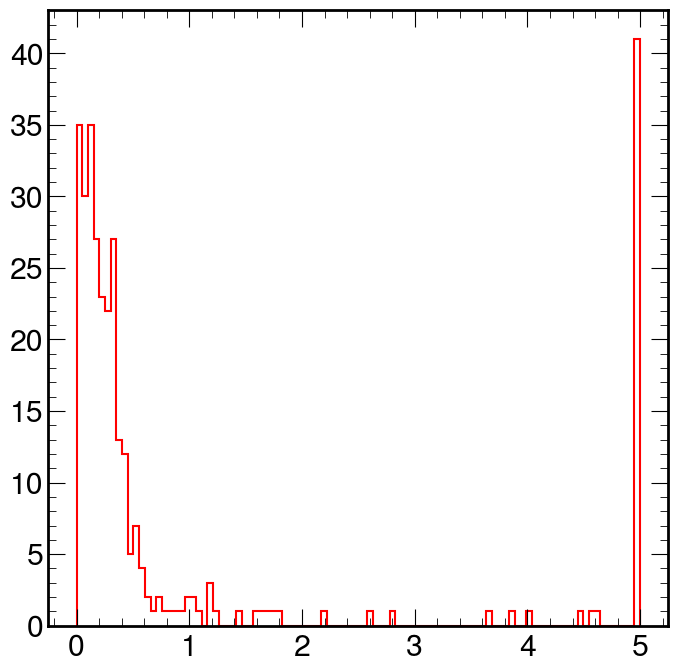

In [17]:
#plots difference of energy_weighted_time and the electron delay

time_bins = np.linspace(0, 5, 100)

#ewtr2_delay_diff_hist = np.histogram(np.clip(ak.flatten(ewtr2), time_bins[0], time_bins[-1]), bins=time_bins)
#ewtr1_delay_diff_hist = np.histogram(np.clip(ak.flatten(ewtr1), time_bins[0], time_bins[-1]), bins=time_bins)

ewtr1_delay_diff_hist = np.histogram(np.clip(ak.flatten(ewt_delay_diff), time_bins[0], time_bins[-1]), bins=time_bins)
coffea_ewtr1_delay_diff_hist = np.histogram(np.clip((ewt), time_bins[0], time_bins[-1]), bins=time_bins)
#ewtr1_delay_diff_hist = np.histogram(np.clip(ak.flatten(ewt_delay_diff), time_bins[0], time_bins[-1]), bins=time_bins)
#coffea_ewtr1_delay_diff_hist = np.histogram(np.clip((ewt_edelay_diff), time_bins[0], time_bins[-1]), bins=time_bins)

#ewtr05_delay_diff_hist = np.histogram(np.clip(ak.flatten(ewtr05), time_bins[0], time_bins[-1]), bins=time_bins)
#ewtr01_delay_diff_hist = np.histogram(np.clip(ak.flatten(ewtr01), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

'''hep.histplot(
    ewtr2_delay_diff_hist[0], #/(ak.sum(ewtr2_delay_diff_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['deltaR < 0.2'],
    color=['green'],
    ax=ax,
    )'''

hep.histplot(
    ewtr1_delay_diff_hist[0], #/(ak.sum(ewtr1_delay_diff_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['deltaR < 0.1'],
    color=['red'],
    ax=ax,
    )

hep.histplot(
    coffea_ewtr1_delay_diff_hist[0], #/(ak.sum(ewtr1_delay_diff_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['coffea'],
    color=['blue'],
    ax=ax,
    )


'''hep.histplot(
    ewtr05_delay_diff_hist[0], #/(ak.sum(ewtr05_delay_diff_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['deltaR < 0.05'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ewtr01_delay_diff_hist[0], #/(ak.sum(ewtr01_delay_diff_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['deltaR < 0.01'],
    color=['magenta'],
    ax=ax,
    )
'''

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/diff_ewt_edelay_ctau0.png')'''

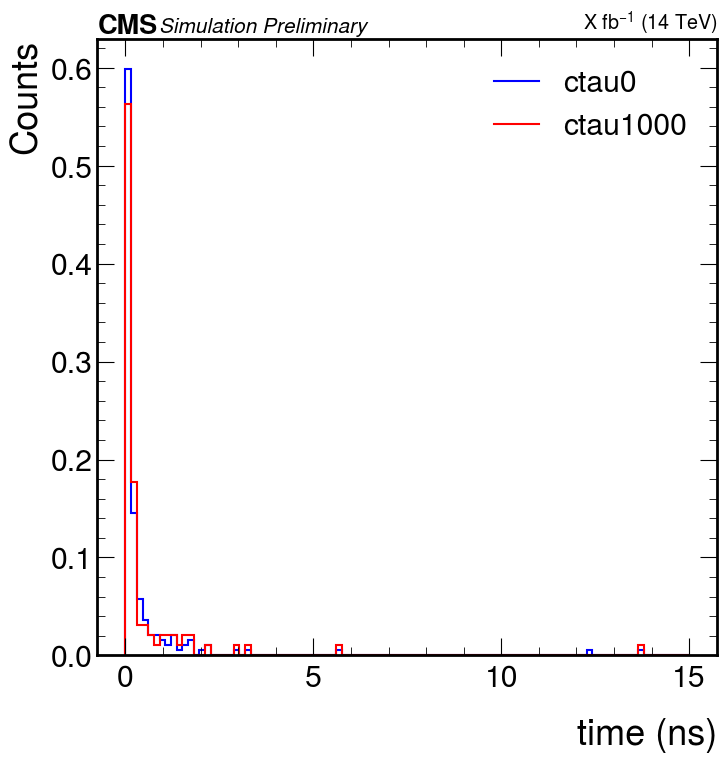

In [58]:
#plots delays for the closest 1 mtd hit that overlap with photon/ele 

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(closest_delay_0, time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(closest_delay, time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/MTD_matches_delays_closest1_norm.png')


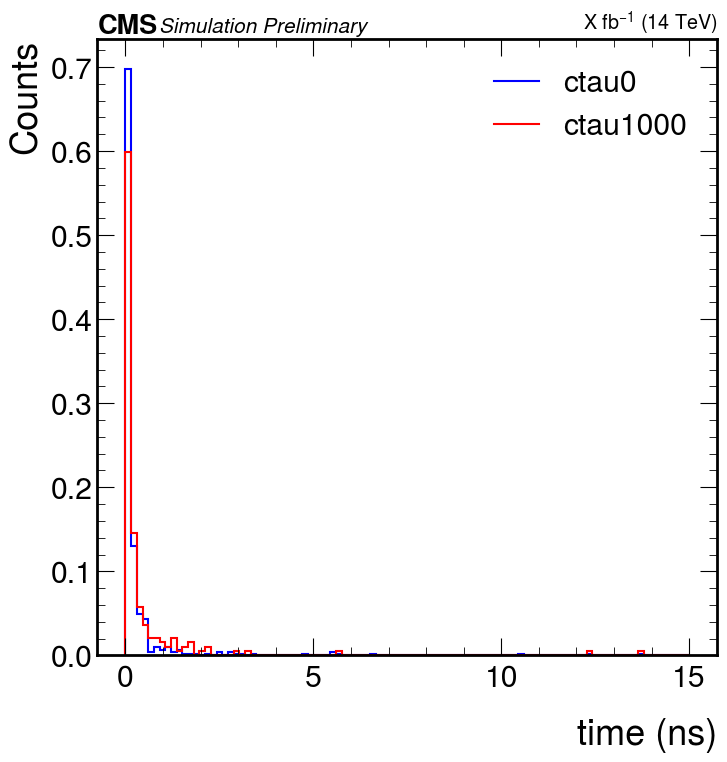

In [57]:
#plots delays for the closest 2 mtd hit that overlap with photon/ele 

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(closest_2delays_0, time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(closest2_delay, time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/MTD_matches_delays_closest2_norm.png')


In [ ]:
'''#plots the time delays for eb and hg
ele_delay_times_0_ns = ele_delay_times_0 * 1e9
ele_delay_times_ns = ele_delay_times * 1e9

time_bins = np.linspace(0, 10, 100)

ctau0_hgeb_hist = np.histogram(np.clip(ak.flatten(ele_delay_times_0_ns), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_hgeb_hist = np.histogram(np.clip(ak.flatten(ele_delay_times_ns), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_hgeb_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_hgeb_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/hg_eb_delays.png')'''

In [ ]:
'''#plots times for mtd hits that overlap with photon/ele 

time_bins = np.linspace(0, 25, 100)
ctau0_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_time_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_time)), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/MTD_times_norm.png')
'''

In [ ]:
'''#plots times for mtd hits that overlap with photon/ele w/ an ele delay time>1ns

time_bins = np.linspace(0, 25, 100)
ctau0_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_time_1ns_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_time_1ns)), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/MTD_times_wdelay>1ns_norm.png')
'''

In [ ]:
'''#plots delays for mtd hits that overlap with photon/ele 

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_delays_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_delays)), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_matches_delays_deltar1.png')
'''

In [ ]:
'''#plots delays for mtd hits that overlap with photon/ele w/ an ele delay time>1ns

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_delays_1ns_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_delays_1ns)), time_bins[0], time_bins[-1]), bins=time_bins)

f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/MTD_matches_delays_norm.png')
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_matches_delays_5ns_ev149.png')
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_matches_delays_10ns.png')

'''

In [ ]:
#plots number of matched mtd hits
time_bins = np.linspace(0, 50, 51)

etl_matches_hist = np.histogram(ak.flatten(num_mtd_pho_hits_etl), bins=time_bins)
btl_matches_hist = np.histogram(ak.flatten(num_mtd_pho_hits_btl), bins=time_bins)
both_matches_hist = np.histogram(ak.flatten(num_pho_match), bins=time_bins)

f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    etl_matches_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['etl'],
    color=['red'],
    ax=ax,
    )
    
hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('# of photons')
ax.set_xlabel('Counts of matches')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/num_etl_mtd_matches.png')



##################3
f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    btl_matches_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['btl'],
    color=['blue'],
    ax=ax,
    )
    
hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('# of photons')
ax.set_xlabel('Counts of matches')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/num_btl_mtd_matches.png')

###############
f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    both_matches_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['etl and btl'],
    color=['red'],
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('# of photons')
ax.set_xlabel('Counts of matches')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/num_btletl_mtd_matches.png')

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
    
plt.scatter(ak.flatten(ak.flatten(btl_time_matches)), ak.flatten(ak.flatten(btl_energy_matches)), color='b', marker='.', label='btl')
plt.scatter(ak.flatten(ak.flatten(etl_time_matches)), ak.flatten(ak.flatten(etl_energy_matches)), color='r', marker='.', label='etl')
    
hep.cms.label(
    "Preliminary",
    data=False,
    #lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Energy (GeV)')
ax.set_xlabel('time')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/full_dataset/E_vs_t.png')

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
    
plt.scatter(ak.flatten(btl_ele_pt), btl_eff, color='b', marker='.', label='btl eff')
plt.scatter(ak.flatten(etl_ele_pt), etl_eff, color='r', marker='.', label='etl eff')
    

hep.cms.label(
    "Preliminary",
    data=False,
    #lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Efficiency')
ax.set_xlabel('pt')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/btletl_eff.png')

In [ ]:
#plots the photons and electrons overlaps, plots the mtd hits that are close
for i in range(len(reco_pho_phi)):
    f, ax = plt.subplots(figsize=(8, 8))
 
    #plt.scatter(overlaps_phi[i], overlaps_eta[i], color='m', marker='s', s=50, label='photon/ele')
    plt.scatter(ak.flatten(mtd_matches_phi[i]), ak.flatten(mtd_matches_eta[i]), color='b', marker='.', label='r<.1')
    
    for j in range(len(overlaps_phi[i])):
        circle = plt.Circle((overlaps_phi[i][j], overlaps_eta[i][j]), 0.1, fill = False )
        ax.set_aspect(1)
        ax.add_artist(circle)
        
    plt.axhline(y=1.5, color='gray', linestyle='--')
    plt.axhline(y=-1.5, color='gray', linestyle='--')

    
    hep.cms.label(
        "Preliminary",
        data=False,
        #lumi='X',
        com=14,
        loc=0,
        ax=ax,
        fontsize=15,
    )

    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\eta$')
    plt.legend(frameon=True, loc=2, prop={'size': 7})
    plt.xlim([-3.1, 3.1])
    plt.ylim([-4, 4])
    plt.show()
    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/event' + str(i) + '.png')
    print("saving fig " + str(i) + " now")
    

In [ ]:
#eta&phi plots with no cuts
for i in range(len(etl_phi)):
    f, ax = plt.subplots(figsize=(8, 8))

    plt.scatter(reco_pho_phi[i], reco_pho_eta[i], color='m', marker='s', s=50, label='reco photon')
    plt.scatter(reco_ele_phi[i], reco_ele_eta[i], color='c', marker='P', s=50, label='electron')
    #plt.scatter(gen_ele_phi[i], gen_ele_eta[i], color='g', marker='X', s=100, label='gen electron')
    plt.scatter(etl_phi[i], etl_eta[i], color='b', marker='.', label='ETL')
    plt.scatter(btl_phi[i], btl_eta[i], color='b', marker='.', label='BTL')
    plt.scatter(track_phi[i], track_eta[i], facecolors='none', edgecolors='r', s=50, label='tracks')
    
    plt.axhline(y=1.5, color='gray', linestyle='--')
    plt.axhline(y=-1.5, color='gray', linestyle='--')


    hep.cms.label(
        "Preliminary",
        data=False,
        #lumi='X',
        com=14,
        loc=0,
        ax=ax,
        fontsize=15,
    )

    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\eta$')
    plt.legend(frameon=True, loc=2, prop={'size': 7})
    plt.show()
    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/test/event' + str(i) + '.png')
    print("saving fig " + str(i) + " now")


In [ ]:
#plots with track pt cut > 5
for i in range(len(etl_phi)):
    f, ax = plt.subplots(figsize=(8, 8))
    
    plt.scatter(reco_pho_phi[i], reco_pho_eta[i], color='m', marker='s', s=50, label='reco photon')
    plt.scatter(reco_ele_phi[i], reco_ele_eta[i], color='c', marker='P', s=50, label='electron')
    #plt.scatter(gen_ele_phi[i], gen_ele_eta[i], color='g', marker='X', s=100, label='gen electron')
    plt.scatter(etl_phi[i], etl_eta[i], color='b', marker='.', label='ETL')
    plt.scatter(btl_phi[i], btl_eta[i], color='b', marker='.', label='BTL')
    plt.scatter(track_phi_w_cut[i], track_eta_w_cut[i], facecolors='none', edgecolors='r', s=50, label='tracks')
    
    plt.axhline(y=1.5, color='gray', linestyle='--')
    plt.axhline(y=-1.5, color='gray', linestyle='--')

    hep.cms.label(
        "Preliminary",
        data=False,
        #lumi='X',
        com=14,
        loc=0,
        ax=ax,
        fontsize=15,
    )

    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\eta$')
    plt.legend(frameon=True, loc=2, prop={'size': 7})
    plt.show()
    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/track_pt_5/event' + str(i) + '.png')
    print("saving fig " + str(i) + " now")


In [ ]:
#plots of time of hits for each event

time_bins = np.linspace(0, 25, 11)

for i in range(len(btl_times)):
    btl_hist = np.histogram(btl_times[i], bins=time_bins)
    etl_hist = np.histogram(etl_times[i], bins=time_bins)

    f, ax = plt.subplots(figsize=(8, 8))

    hep.histplot(
        btl_hist[0],
        time_bins,
        histtype="step",
        stack=False,
        label=['btl'],
        color=['blue'],
        ax=ax,
        )

    hep.histplot(
        etl_hist[0],
        time_bins,
        histtype="step",
        stack=False,
        label=['etl'],
        color=['red'],
        ax=ax,
        )

    hep.cms.label(
        "Preliminary",
        data=False,
        lumi='X',
        com=14,
        loc=0,
        ax=ax,
        fontsize=15,
    )

    ax.set_ylabel('Counts')
    ax.set_xlabel('time')

    plt.legend()
    plt.show()

    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/times/event' + str(i) + '.png')
    print("saving fig " + str(i) + " now")

In [ ]:
for i in range(len(btl_times)):
    btl_hist = np.histogram(btl_time_diff[i], bins=time_bins)
    etl_hist = np.histogram(etl_time_diff[i], bins=time_bins)

    f, ax = plt.subplots(figsize=(8, 8))

    hep.histplot(
        btl_hist[0],
        time_bins,
        histtype="step",
        stack=False,
        label=['btl'],
        color=['blue'],
        ax=ax,
        )

    hep.histplot(
        etl_hist[0],
        time_bins,
        histtype="step",
        stack=False,
        label=['etl'],
        color=['red'],
        ax=ax,
        )

    hep.cms.label(
        "Preliminary",
        data=False,
        lumi='X',
        com=14,
        loc=0,
        ax=ax,
        fontsize=15,
    )

    ax.set_ylabel('Counts')
    ax.set_xlabel('time')

    plt.legend()
    plt.show()
    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/time_diffs/event' + str(i) + '.png')
    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/time_diffs_ctau/event' + str(i) + '.png')
    print("saving fig " + str(i) + " now")

    
btl_hist = np.histogram(ak.flatten(btl_time_diff), bins=time_bins)
etl_hist = np.histogram(ak.flatten(etl_time_diff), bins=time_bins)

f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    btl_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['btl'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    etl_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['etl'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time')
plt.show()
plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/time_diffs/combined_events.png')
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/time_diffs_ctau/combined_events.png')
print("saving fig combined now")